In [1]:
import os
import gc
import cv2

import numpy as np
import joblib

from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import albumentations as A
from IPython.display import display
from PIL import Image


c:\Users\i.kasionis\AppData\Local\anaconda3\envs\msc\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# ======================
# Configuration
# ======================
TARGET_SIZE = (128, 128)
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
COLOR_BINS = 64  # Increased from 32
SIFT_CLUSTERS = 50

# Toggle PCA usage. (Sometimes disabling PCA helps when using handcrafted features.)
USE_PCA = False  # Try setting to False if needed
# Toggle SIFT
USE_SIFT = True
# Adjust the threshold probability for multi-class predictions during inference.
THRESHOLD_PROB = 0.10  # Lowering from 0.2 may yield more detections
# Toggle Image Augmentation
USE_AUG = True

# Toggle hyperparameter tuning
DO_HYPERPARAMETER_TUNING = True

# Path configurations
POKEMON_DIR = 'pokemon-data'
NO_POKEMON_DIR = 'no-pokemon'
MODEL_SAVE_DIR = 'models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Data Augmentation Pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1])
])

In [3]:
def transform_image(img, target_size=TARGET_SIZE):
    """
    Reads an image from disk, ensures it is 8-bit RGB, and resizes it to the target size.
    This function should be used during both training and inference.
    """
    if img is None:
        return None
    
    if img.dtype != np.uint8:
        img = cv2.convertScaleAbs(img)
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image

    img = cv2.resize(img, target_size)
    return img

def load_images(path, target_size=TARGET_SIZE):
    images = []
    for fname in os.listdir(path):
        img_path = os.path.join(path, fname)
        # Read image with unchanged flag to capture any alpha channels or unusual bit depths
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = transform_image(img)
        if img is not None:
            if USE_AUG:
                augmented = transform(image=img)
                augmented_img = augmented['image']
                images.append(augmented_img)      
            images.append(img)
    return images

In [4]:
# ======================
# Load and Transform Images for each class
# ======================
multi_images = []
multi_labels = []
for pname in os.listdir(POKEMON_DIR):
    imgs = load_images(os.path.join(POKEMON_DIR, pname))
    multi_images += imgs
    multi_labels += [pname] * len(imgs)

3180


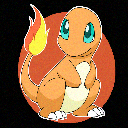

In [7]:
print(len(multi_images))
display(Image.fromarray(multi_images[1000]))

In [11]:
# ======================
# Feature Extraction
# ======================
class FeatureExtractor:
    def __init__(self, sift_kmeans=None):
        if USE_SIFT:
            self.sift = cv2.SIFT_create()
            self.kmeans = sift_kmeans
        self.scaler_bin = StandardScaler()
        self.scaler_multi = StandardScaler()

    def extract_basic_features(self, img):
        """Enhanced color-aware feature extraction"""
        # Convert image to grayscale for HOG and LBP
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # --- HOG Features (Grayscale) ---
        hog_features = hog(
            gray,
            orientations=HOG_ORIENTATIONS,
            pixels_per_cell=HOG_PIXELS_PER_CELL,
            cells_per_block=HOG_CELLS_PER_BLOCK,
            block_norm='L2-Hys'
        )
        # Note: Instead of computing HOG on each color channel, we use the grayscale image.

        # --- LBP Features (Grayscale) ---
        # Compute LBP on the grayscale image
        P = 8  # Number of circularly symmetric neighbor set points
        R = 1  # Radius
        n_bins_lbp = P + 2  # For uniform patterns
        lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins_lbp, range=(0, n_bins_lbp))
        lbp_features = hist.astype('float')
        lbp_features /= (lbp_features.sum() + 1e-7)
        
        # --- Color Histograms ---
        # Compute histograms in both HSV and LAB color spaces.
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        color_features = []
        # HSV histograms:
        h_hist, _ = np.histogram(hsv[:, :, 0].ravel(), bins=COLOR_BINS, range=(0, 180))
        s_hist, _ = np.histogram(hsv[:, :, 1].ravel(), bins=COLOR_BINS, range=(0, 256))
        v_hist, _ = np.histogram(hsv[:, :, 2].ravel(), bins=COLOR_BINS, range=(0, 256))
        h_hist = h_hist.astype('float') / (h_hist.sum() + 1e-7)
        s_hist = s_hist.astype('float') / (s_hist.sum() + 1e-7)
        v_hist = v_hist.astype('float') / (v_hist.sum() + 1e-7)
        color_features.extend([h_hist, s_hist, v_hist])
        # LAB histograms:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        for channel in range(3):
            lab_hist, _ = np.histogram(lab[:, :, channel].ravel(), bins=COLOR_BINS, range=(0, 256))
            lab_hist = lab_hist.astype('float') / (lab_hist.sum() + 1e-7)
            color_features.append(lab_hist)
        color_features = np.concatenate(color_features)
        
        # --- Final Feature Vector ---
        return np.concatenate([hog_features, lbp_features, color_features])

    def extract_sift_features(self, img):
        """Color-enhanced SIFT using dominant color channel.
           Note: Consider using a dense sampling strategy if keypoint detection is too sparse.
        """
        variances = [np.var(img[:, :, i]) for i in range(3)]
        dominant_channel = np.argmax(variances)
        _, des = self.sift.detectAndCompute(img[:, :, dominant_channel], None)
        if des is None or len(des) < 5:
            return np.zeros(SIFT_CLUSTERS)
        clusters = self.kmeans.predict(des)
        return np.bincount(clusters, minlength=SIFT_CLUSTERS)

    def extract_all_features(self, img):
        basic = self.extract_basic_features(img)
        if USE_SIFT:
            sift = self.extract_sift_features(img)
            return np.hstack([basic, sift])
        return np.hstack([basic])


In [12]:
# ======================
# Training Pipeline
# ======================
def train_sift_codebook(images):
    sift = cv2.SIFT_create()
    descriptors = []
    
    for img in images:
        variances = [np.var(img[:, :, i]) for i in range(3)]
        dominant_channel = np.argmax(variances)
        _, des = sift.detectAndCompute(img[:, :, dominant_channel], None)
        if des is not None:
            descriptors.append(des)
    
    if len(descriptors) == 0:
        raise ValueError("No SIFT descriptors found in any image!")
    
    all_descriptors = np.vstack(descriptors)
    kmeans = MiniBatchKMeans(n_clusters=SIFT_CLUSTERS, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans

if USE_SIFT:
    print("Training SIFT codebook...")
    sift_kmeans = train_sift_codebook(multi_images)
    joblib.dump(sift_kmeans, os.path.join(MODEL_SAVE_DIR, 'sift_kmeans.pkl'))
            # Initialize feature extractor        
    fe = FeatureExtractor(sift_kmeans)
else:
    fe = FeatureExtractor()

Training SIFT codebook...


c:\Users\i.kasionis\AppData\Local\anaconda3\envs\msc\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [13]:
# ======================
# Feature Extraction for Multi-class Classification
# ======================
print("\nTraining multi-class classifiers...")
le = LabelEncoder()
y_multi = le.fit_transform(multi_labels)
    
print("Extracting features...")
X_multi = [fe.extract_all_features(img) for img in tqdm(multi_images, desc='Processing images')]
X_multi = fe.scaler_multi.fit_transform(X_multi)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
X_multi, y_multi, test_size=0.2, stratify=y_multi, random_state=42)

pca_multi = None
if USE_PCA:
    pca_multi = PCA(n_components=0.95, random_state=42)
    X_train_multi = pca_multi.fit_transform(X_train_multi)
    X_test_multi = pca_multi.transform(X_test_multi)
    joblib.dump(pca_multi, os.path.join(MODEL_SAVE_DIR, 'pca_multi.pkl'))


Training multi-class classifiers...
Extracting features...


Processing images: 100%|██████████| 3180/3180 [00:59<00:00, 53.77it/s]


In [14]:
# Define multi-class models along with their parameter grids.
models = {
#'XGBoost': (XGBClassifier(random_state=42), {
#    'n_estimators': [50],
#    'learning_rate': [0.1],
#    'max_depth': [3]
#}),
#'SVM-RBF': (SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'), {
#    'C': [1],
#    'gamma': ['scale']
#}),
#'kNN': (KNeighborsClassifier(weights='distance'), {
#    'n_neighbors': [5],
#    'weights': ['uniform']
#}),
'RForest': (RandomForestClassifier(random_state=42, class_weight='balanced'), {
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': [None],
    'n_jobs': [-1],
    'class_weight': ["balanced"],
    'verbose': [1]
})
}
for model_name, (model, param_grid) in models.items():
    if DO_HYPERPARAMETER_TUNING:
        print(f"\nTuning {model_name}...")
        grid = GridSearchCV(
            model, param_grid, cv=3, scoring='accuracy', n_jobs=4, verbose=2
        )
        grid.fit(X_train_multi, y_train_multi)
        print(f"Best parameters for {model_name}:", grid.best_params_)
        best_model = grid.best_estimator_
    else:
        best_model = model.fit(X_train_multi, y_train_multi)
    
    y_pred = best_model.predict(X_test_multi)
    print(f"\n{model_name} Performance:")
    print(classification_report(le.inverse_transform(y_test_multi), 
                                le.inverse_transform(y_pred)))
      
    joblib.dump(best_model, os.path.join(MODEL_SAVE_DIR, f'multi_clf_{model_name.lower()}.pkl'))

joblib.dump(fe.scaler_bin, os.path.join(MODEL_SAVE_DIR, 'scaler_bin.pkl'))
joblib.dump(fe.scaler_multi, os.path.join(MODEL_SAVE_DIR, 'scaler_multi.pkl'))
joblib.dump(le, os.path.join(MODEL_SAVE_DIR, 'label_encoder.pkl'))
    
print("\nTraining complete! Models saved to:", MODEL_SAVE_DIR)


Tuning RForest...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min


Best parameters for RForest: {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'verbose': 1}

RForest Performance:
              precision    recall  f1-score   support

   Blastoise       0.84      0.91      0.87        57
   Bulbasaur       0.79      0.80      0.80        56
   Charizard       0.74      0.78      0.76        41
  Charmander       0.81      0.71      0.76        48
  Charmeleon       0.91      0.88      0.89        58
     Ivysaur       0.57      0.63      0.60        60
     Pikachu       0.77      0.82      0.80        79
      Raichu       0.79      0.75      0.77        65
    Squirtle       0.80      0.66      0.73        62
    Venusaur       0.67      0.76      0.71        55
   Wartortle       0.80      0.71      0.75        55

    accuracy                           0.77       636
   macro avg       0.77      0.77      0.77       636
weighted avg       0.77  

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [15]:
# ======================
# Inference Pipeline
# ======================
class PokemonDetector:
    def __init__(self, model_name='rforest'):
        if USE_SIFT:
            self.sift_kmeans = joblib.load(os.path.join(MODEL_SAVE_DIR, 'sift_kmeans.pkl'))
            self.fe = FeatureExtractor(self.sift_kmeans)
        else:
            self.fe = FeatureExtractor()
        self.multi_clf = joblib.load(os.path.join(MODEL_SAVE_DIR, f'multi_clf_{model_name.lower()}.pkl'))
        self.le = joblib.load(os.path.join(MODEL_SAVE_DIR, 'label_encoder.pkl'))
        self.scaler_bin = joblib.load(os.path.join(MODEL_SAVE_DIR, 'scaler_bin.pkl'))
        self.scaler_multi = joblib.load(os.path.join(MODEL_SAVE_DIR, 'scaler_multi.pkl'))
        
        self.use_pca = USE_PCA
        if self.use_pca:
            self.pca_bin = joblib.load(os.path.join(MODEL_SAVE_DIR, 'pca_bin.pkl'))
            self.pca_multi = joblib.load(os.path.join(MODEL_SAVE_DIR, 'pca_multi.pkl'))
    
    def predict(self, image_path):
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            return []
        predictions = []

        img_resized = transform_image(img)
        features = self.fe.extract_all_features(img_resized)
        features = self.scaler_multi.transform([features])
        if self.use_pca:
                features = self.pca_multi.transform(features)
        
        pred_probs = self.multi_clf.predict_proba(features)[0]
        pred = np.argmax(pred_probs)
        
        class_labels = self.le.inverse_transform(np.arange(len(pred_probs)))  # Get class labels
        for label, prob in zip(class_labels, pred_probs):
            print(f"Class: {label}, Probability: {prob:.4f}")
        
        
        prediction = self.le.inverse_transform([pred])[0]
        predictions.append(prediction)

        print(prediction, pred_probs[pred])
        display(Image.fromarray(img_resized))
        
        return list(set(predictions))

Class: Blastoise, Probability: 0.0124
Class: Bulbasaur, Probability: 0.0000
Class: Charizard, Probability: 0.2411
Class: Charmander, Probability: 0.0900
Class: Charmeleon, Probability: 0.0411
Class: Ivysaur, Probability: 0.0085
Class: Pikachu, Probability: 0.0417
Class: Raichu, Probability: 0.5127
Class: Squirtle, Probability: 0.0162
Class: Venusaur, Probability: 0.0078
Class: Wartortle, Probability: 0.0286
Raichu 0.512710402855578


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


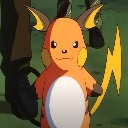

Predictions on test_raichu.png: ['Raichu']
Class: Blastoise, Probability: 0.2800
Class: Bulbasaur, Probability: 0.0012
Class: Charizard, Probability: 0.0174
Class: Charmander, Probability: 0.0133
Class: Charmeleon, Probability: 0.0220
Class: Ivysaur, Probability: 0.0436
Class: Pikachu, Probability: 0.0212
Class: Raichu, Probability: 0.0179
Class: Squirtle, Probability: 0.1456
Class: Venusaur, Probability: 0.0339
Class: Wartortle, Probability: 0.4040
Wartortle 0.4039730320561169


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


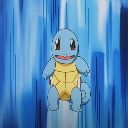

Predictions on test_squirtle.png: ['Wartortle']
Class: Blastoise, Probability: 0.0062
Class: Bulbasaur, Probability: 0.0018
Class: Charizard, Probability: 0.1003
Class: Charmander, Probability: 0.4170
Class: Charmeleon, Probability: 0.0712
Class: Ivysaur, Probability: 0.0105
Class: Pikachu, Probability: 0.2259
Class: Raichu, Probability: 0.1491
Class: Squirtle, Probability: 0.0015
Class: Venusaur, Probability: 0.0105
Class: Wartortle, Probability: 0.0059
Charmander 0.41703963988486764


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


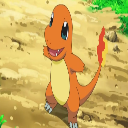

Predictions on test_charmander.png: ['Charmander']


In [16]:
# Example usage
detector = PokemonDetector(model_name='rforest')

print("Predictions on test_raichu.png:", detector.predict("manual-test-images/test_raichu.png"))
print("Predictions on test_squirtle.png:", detector.predict("manual-test-images/test_squirtle.png"))
print("Predictions on test_charmander.png:", detector.predict("manual-test-images/test_charmander.png"))